<a href="https://colab.research.google.com/github/FredLongo/Big-Data-Analytics-Project/blob/main/Big_Data_Team_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Analitics
## Team Project
### Team Members
*   Alfredo Longo
*   Chandramouli Prabhakaran  
*   Cody Zehner
*   Sashank Ganapathy Subramaniam  

### Description
This Project is used to see if we can predict Bitcoin Stock Prices.  In this project we try Several diffrent things to see what can produce the best result.

* We try Two diffrent Time series Model One just one layer and one having three layers

* We also try two diffrent configeration for the (candlestick size) a ten day frame and a 100 day frame

* To give the model more comparitive information to train with we added a Maket indicator to the stock.  We do this so it can have a sence of what the overall market is doing for that day.




#Code Section

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
pip install pandas_ta

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import warnings
from datetime import datetime, timedelta


"""#Now build the model"""
from re import VERBOSE
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

""" performance evaluation """
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import csv
pd.set_option('display.max_columns', None)




In [97]:
class MyLSTMModel:
    def __init__(self, indicators='^DJI',
                 ticker='ADM',
                 frame_days=10,
                 lstm_layers = 1,
                 start_date = '2016-01-01',   # Bitcon only has info back to mid 2015
                 end_date='2024-06-10',
                 batch_size=15,
                 epochs=30,
                 run = False,
                 run_all=False,
                 verbose=1,
                 name=''):
        #Parameters
        self.name           = name
        self.indicators     = indicators
        self.ticker         = ticker
        self.run            = run
        self.run_all        = run_all
        #Data Setup
        self.start_date     = start_date
        self.end_date       = end_date
        self.frame_days     = frame_days
        self.ticker_list    = indicators + ',' +ticker
        self.ticker_list_ct  = len(self.ticker_list.split(','))
        self.tickers        = self.ticker_list.split(',')
        self.data = pd.DataFrame()
        #Model Setup
        self.model          = None
        self.lstm_layers    = lstm_layers
        self.lstm_nodes     = 0
        self.batch_size     = batch_size
        self.epochs         = epochs
        self.verbose        = verbose
        #Report
        self.pred_diff    = np.array([])
        self.pred_diff_bias  = np.array([])
        self.pred_correctness = np.array([])
        self.pred_correctness_mean = np.array([])
        self.history = np.array([])
        self.fitting_elapse_time = None
        self.root_mean_sqr_err = None
        #Misc
        self.data_set = pd.DataFrame()
        self.data_set_scaled = np.array([])
        self.X        = np.array([])              # X[Column][Sample][Frame_day]
        self.X_train  = np.array([])
        self.X_test   = np.array([])
        self.y_train  = np.array([])
        self.y_test   = np.array([])
        self.y_pred   = np.array([])
        self.y_test_trend = [0]
        self.y_pred_trend = [0]
        self.scaler = None


        if self.name == '':
          self.name = ticker + '_F' + str(frame_days) + '_L' + str(lstm_layers)

        if self.run or self.run_all:
          self.Run()


    def Data__LoadAndPrep(self):
        #Download Data from Yahoo Finance
        self.data = yf.download(tickers=self.tickers, start=self.start_date, end=self.end_date)

        # Add all additional indicators
        for (_type, _ticker) in self.data.columns:
          if _type == 'Close':
            rsi_values = ta.rsi(self.data[(_type, _ticker)], length=15)
            self.data[('RSI', _ticker)] = rsi_values
            emaf_values = ta.rsi(self.data[(_type, _ticker)], length=20)
            self.data[('EMAF', _ticker)] = rsi_values
            emam_values = ta.rsi(self.data[(_type, _ticker)], length=100)
            self.data[('EMAM', _ticker)] = rsi_values
            emas_values = ta.rsi(self.data[(_type, _ticker)], length=150)
            self.data[('EMAS', _ticker)] = rsi_values

        # Add the Training an validation column info.
        self.data[('Target',self.ticker)] = self.data['Adj Close',self.ticker]-self.data['Open',self.ticker]                                # 1) Diff of current open and future close
        self.data[('Target',self.ticker)] = self.data['Target',self.ticker].shift(-1)                                                       #
        self.data[('TargetClass',self.ticker)] = [1 if self.data[('Target',self.ticker)][i]>0 else 0 for i in range(len(self.data))]        # 2) Classificaton approche 1= up 0 = down.
        self.data[('TargetNextClose',self.ticker)] = self.data[('Adj Close',self.ticker)].shift(-1)                                         # 3) Closing Price of the next day

        #Remove unused columns
        self.data.dropna(inplace=True)                                                       # Dropping values not their
        self.data.reset_index(inplace = True)                                                # rebuild index after removed values

        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
          self.data.drop([('Close', self.ticker)], axis=1, inplace=True)                       # Removing because we are going with Adjuested Close
          self.data.drop(['Date'], axis=1, inplace=True)                                       # Removing unsued Columns  (R1)

        # Save Processed input to CSV file for Logging
        current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'/content/drive/MyDrive/Classes/Kent/Big Data Analytics/Data/Input_Data_Processed_{current_datetime}.csv'
        self.data.to_csv(filename , index=False)

    def reverse_scaling(self, data):
        return self.scaler.inverse_transform(data)


    def Data_Set__LoadAndPrep(self):
        self.data_set = self.data.iloc[:,0:len(self.data.columns)]#.values
        # Scale the dataset
        self.scaler = MinMaxScaler(feature_range=(0,1))             # Apply Scaler to our data to make it between 0 and `
        self.data_set_scaled = self.scaler.fit_transform(self.data_set)


    def Data_Prep_Input(self):
        # Create frame of given candles
        self.X = []

        for j in range(len(self.data_set.columns) -1):#data_set_scaled[0].size):#2 columns are target not X         # Removing some of the columns  Adding volume
            self.X.append([])
            for i in range(self.frame_days, self.data_set_scaled.shape[0]):#framedays+2
                self.X[j].append(self.data_set_scaled[i-self.frame_days:i, j])

        #Swith Order, move axis from 0 to last position 2                               # Moves  X[Column][Sample][Frame_day]
                                                                                        #   to   X[Sample][Frame_day][Column]
        self.X = np.moveaxis( self.X, [0], [2])


        # Choose -1 for last column, classification else -2...
        self.X, yi =np.array(self.X), np.array(self.data_set_scaled[self.frame_days:,-1])
        y=np.reshape(yi,(len(yi),1))

        # split data into train test sets
        splitlimit = int(len(self.X)*0.8)          #point to slit at
        self.X_train, self.X_test = self.X[:splitlimit], self.X[splitlimit:]
        self.y_train, self.y_test = y[:splitlimit], y[splitlimit:]

        ############################################################
        ##   Build Model
        ############################################################
    def Build_Model(self):
        self.lstm_nodes = len(self.X[0][0])
        lstm_input = Input(shape=(self.frame_days, self.lstm_nodes), name='lstm_input')      # Input layer
        current_inputs = lstm_input  # first time needs to be input layer (lstm_input) after that (inputs)
        for l in reversed(range(self.lstm_layers)):
          layer_name = f'lstm_layer_{self.lstm_layers - l}'
          if 0 != l:
            inputs = LSTM(self.lstm_nodes, return_sequences=True, name=layer_name)(current_inputs)
          else:
            inputs = LSTM(self.lstm_nodes, name=layer_name)(current_inputs)
          current_inputs = inputs
        inputs = Dense(1, name='dense_layer')(inputs)                                          # One Dense Layer
        output = Activation('linear', name='output')(inputs)                                   # Output layer
        self.model = Model(inputs=lstm_input, outputs=output)                                  # declare model
        adam = optimizers.Adam()                                                               # instanciate optimizer
        self.model.compile(optimizer=adam, loss='mse', metrics=['mae'])
#        print(f'Model Layers:')                      # Compile model
#        for ml in self.model.layers:
#            print(ml.name)

    def Fit(self):
        start_time = datetime.now()
        print(f'___________{self.name}___________')
        print(f'Start Time:{start_time}')
        self.history = self.model.fit(x=self.X_train,
                       y=self.y_train,
                       batch_size=self.batch_size,
                       epochs=self.epochs, #TODO Set back to 30
                       shuffle=False,
                       validation_data=(self.X_test, self.y_test),
                       verbose=self.verbose)
        end_time = datetime.now()
        self.fitting_elapse_time = end_time - start_time
        print(f'End Time:{end_time}')
        print(f'Elapse Time:{self.fitting_elapse_time}')


    def Predict(self):
      self.y_pred = self.model.predict(self.X_test)

        ############################################################
        ### Evaluation and reports
        ############################################################
    def check_sign(self,number):
        if number > 0:
            return 1
        elif number < 0:
            return -1
        else:
            return 0


    def calculate_aic(self,y_true, y_pred,n_params):

        mse = mean_squared_error(y_true, y_pred)
        n = len(y_true)
        aic = n * np.log(mse) + 2 * n_params
        return aic



     # X_test = Open,	High,	Low,	Adj Close,	Volume,	RSI	EMAF,	EMAM,	EMAS,

    def Get_diffs(self):
        _size = self.y_test.shape[0]
        self.pred_correctness   = np.zeros(_size)
        self.pred_diff          = np.zeros(_size)
        self.pred_diff_bias      = np.zeros(_size)

        for i in range(_size):                                 # X[Sample][Frame_day][column]
          Opening    =  self.X_test[i][0][(self.ticker_list_ct * 4) -1]                        # Opening column for ticker is always (ticker_count * 4 -1)
          Actual     =  self.y_test[i]
          Predicted  =  self.y_pred[i]
          with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            self.pred_diff[i]    = Predicted/Actual
            self.pred_diff_bias[i]  = 1 - (Predicted/Actual)
            if self.check_sign(Opening - Actual) == self.check_sign(Opening - Predicted):
              self.pred_correctness[i] = True;                                  #It predicted Correct!
            else: self.pred_correctness[i] = False;                             #It did predict correctly


                #Mean Squre Error
        self.mean_sqr_err =  mean_squared_error(self.y_test, self.y_pred)

        # Mean absolute Error
        self.mean_abs_err = mean_absolute_error(self.y_test, self.y_pred)

        self.pred_correctness_mean = self.pred_correctness.mean()
        self.pred_diff_mean = self.pred_diff.mean()
        self.pred_diff_bias_mean  = self.pred_diff_bias.mean()

        #AIC
        self.aic = self.calculate_aic(self.y_test,self.y_pred,self.lstm_nodes)




         # R^2    = ?????


    def View_Performance_Report(self,show_graphs=True, show_report=True , graphs=[]):


        # Root Mean Squred Error.
        self.root_mean_sqr_err = math.sqrt(self.mean_sqr_err)
        print("############################################################################")
        print("  Model Setup:")
        print(f"                    Name: {self.name}")
        print(f"             LSTM_Layers: {self.lstm_layers}")
        print(f"              LSTM_Nodes: {self.lstm_nodes}")
        print(f"               Bach_Size: {self.batch_size}")
        print(f"                  Epochs: {self.epochs}")
        print("  Data Setup:")
        print(f"                  Ticker: {self.ticker}")
        print(f"             Indicattors: {self.indicators}")
        print(f"              Start_Date: {self.start_date}")
        print(f"                End_Date: {self.end_date}")
        print(f"              Frame_Days: {self.frame_days}")
        print("  Result Data:")
        print(f'             mean_abs_err ={self.mean_abs_err}')
        print(f'             mean_sqr_err ={self.mean_sqr_err}')
        print(f'        root_mean_sqr_err ={self.root_mean_sqr_err}')
        print(f'           pred_diff_mean ={self.pred_diff_mean}')
        print(f'      pred_diff_bias_mean ={self.pred_diff_bias_mean}')
        print(f'    pred_correctness_mean ={self.pred_correctness_mean}')
        print(f'                      AIC ={self.aic}')

        print("")

        #Plot Graph
        if  ('Eval_Loss' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Mean Absolute Error
          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(self.history.history['mae'])
          plt.plot(self.history.history['val_mae'])
          plt.title('Evaluation Metric - Mean Absolute Error (MAE)')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')

          # Plot training & validation loss values
          plt.subplot(1, 2, 2)
          plt.plot(self.history.history['loss'])
          plt.plot(self.history.history['val_loss'])
          plt.title('Model Loss - Mean Sqr Error (MSE) ')
          plt.ylabel('Loss')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')
          plt.show()

        if  ('TrainingMAE' in graphs) or (show_graphs == True) :
          #####Break Down
          plt.figure(figsize=(12, 6))

          #plt.subplot(1, 1, 1)
          plt.plot(self.history.history['mae'])
          plt.title('Training Mean Absolute Error')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train'], loc='upper left')
          plt.show()


        if  ('ActVsPed_Line' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Actual vs Predicted Chart
          plt.figure(figsize=(16,8))
          plt.title('Actual Vs Prediction Results')
          plt.plot(self.y_test, color = 'black', label = 'Test')
          plt.plot(self.y_pred, color = 'green', label = 'pred')
          plt.legend()
          plt.show()

        if  ('ActVsPed_Pie' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Pie Chart
          values = [self.pred_correctness_mean, 1 - self.pred_correctness_mean ]
          labels = [f'Correctly Predicted {self.pred_correctness_mean:.2f}%', f'Incorrect{1 - self.pred_correctness_mean:.2f}%']
          colors = ['g','r']
          explode = [0.1, 0]
          plt.title(f'Correct Prediction " {self.pred_correctness_mean:.2f}%  "of the time')
          plt.pie(values, labels=labels, colors=colors, explode=explode)
          plt.show



    def Run(self):
      self.Data__LoadAndPrep()
      self.Data_Set__LoadAndPrep()
      self.Data_Prep_Input()
      self.Build_Model()
      self.Fit()
      self.Predict()
      self.Get_diffs()
      if self.run_all == True:
        self.View_Performance_Report()









In [98]:
def SaveDataToCSV(_model_list,_ticker_symble):
  # Specify the CSV file name
  current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
  filename = f'/content/drive/MyDrive/Classes/Kent/Big Data Analytics/Results/{_ticker_symble}_Results_{current_datetime}.csv'

  # Field names in the CSV file
  fields = ['ModelName','Layers','Batch_Size', 'Epoch','Ticker','Indicators','Frame_Days','mean_abs_err','mean_sqr_err','root_mean_sqr_err','pred_diff_mean','pred_diff_bias_mean','elapsTime','pred_correctness_mean','AIC']

  # Writing to the csv file
  with open(filename, mode='w', newline='') as file:
      writer = csv.DictWriter(file, fieldnames=fields)

      # Writing headers (field names)
      writer.writeheader()

      # Writing data of each object
      for m in _model_list:
          writer.writerow({'ModelName': m.name,
                           'Layers':m.lstm_layers,
                           'Batch_Size': m.batch_size,
                           'Epoch':m.epochs,
                           'Ticker':m.ticker,
                           'Indicators':m.indicators,
                           'Frame_Days':m.frame_days,
                           'mean_abs_err':m.mean_abs_err,
                           'mean_sqr_err':m.mean_sqr_err,
                           'root_mean_sqr_err':m.root_mean_sqr_err,
                           'pred_diff_mean':m.pred_diff_mean,
                           'pred_diff_bias_mean':m.pred_diff_bias_mean,
                           "elapsTime":m.fitting_elapse_time,
                           "pred_correctness_mean":m.pred_correctness_mean,
                           "AIC":m.aic
                            })


# Get Fields








# Model Fit Section

# Model Training

In [99]:
#Indicators    = '^DJI,^BSESN,^BVSP'
Indicators    = '^DJI'
#Ticker = ['ADM','MSI','XOM']
#frame_days = [10,25,50,75,100]
#LSTM_layers = [1,2,3,4,5]


#AMD
#Ticker = ['ADM']
#frame_days = [10,25,50,75,100]
#LSTM_layers = [1,2,3,4,5]

#MSI
Ticker = ['BTC']
frame_days = [10,100]
LSTM_layers = [1,2]

#XOM
#Ticker = ['XOM']
#frame_days = [10,25,50,75,100]
#LSTM_layers = [1,2,3,4,5]



Number_of_Models_to_Test = len(Ticker) * len(frame_days) *  len(LSTM_layers)

print(f'Testing {Number_of_Models_to_Test} model(s)')


Testing 4 model(s)


In [100]:


for t in Ticker:
  model_list = []
  for f in frame_days:
    for l in LSTM_layers:
      new_model = MyLSTMModel(indicators= Indicators,
                              ticker=t,
                              frame_days=f,
                              lstm_layers=l,
                              verbose=2,
                              run=True)
      model_list.append(new_model)

  #Best_Model = max(model_list, key=lambda m:m.pred_diff_mean)
  #print(f"Best Model is {Best_Model.name} with {Best_Model.pred_diff_mean:.2f}%  !!!")
  SaveDataToCSV(model_list,t)



[*********************100%%**********************]  2 of 2 completed


___________BTC_F10_L1___________
Start Time:2024-06-23 13:32:29.275936
Epoch 1/30
48/48 - 7s - loss: 0.1459 - mae: 0.3024 - val_loss: 0.1048 - val_mae: 0.3035 - 7s/epoch - 151ms/step
Epoch 2/30
48/48 - 1s - loss: 0.0323 - mae: 0.1561 - val_loss: 0.0898 - val_mae: 0.2790 - 590ms/epoch - 12ms/step
Epoch 3/30
48/48 - 0s - loss: 0.0118 - mae: 0.0922 - val_loss: 0.0725 - val_mae: 0.2474 - 437ms/epoch - 9ms/step
Epoch 4/30
48/48 - 0s - loss: 0.0089 - mae: 0.0748 - val_loss: 0.0656 - val_mae: 0.2346 - 472ms/epoch - 10ms/step
Epoch 5/30
48/48 - 1s - loss: 0.0083 - mae: 0.0717 - val_loss: 0.0611 - val_mae: 0.2257 - 548ms/epoch - 11ms/step
Epoch 6/30
48/48 - 1s - loss: 0.0082 - mae: 0.0712 - val_loss: 0.0584 - val_mae: 0.2204 - 556ms/epoch - 12ms/step
Epoch 7/30
48/48 - 0s - loss: 0.0082 - mae: 0.0720 - val_loss: 0.0568 - val_mae: 0.2171 - 479ms/epoch - 10ms/step
Epoch 8/30
48/48 - 1s - loss: 0.0083 - mae: 0.0729 - val_loss: 0.0556 - val_mae: 0.2147 - 505ms/epoch - 11ms/step
Epoch 9/30
48/48 - 1

[*********************100%%**********************]  2 of 2 completed


___________BTC_F10_L2___________
Start Time:2024-06-23 13:32:57.394225
Epoch 1/30
48/48 - 10s - loss: 0.2167 - mae: 0.3650 - val_loss: 0.0359 - val_mae: 0.1717 - 10s/epoch - 215ms/step
Epoch 2/30
48/48 - 0s - loss: 0.0960 - mae: 0.2592 - val_loss: 0.0541 - val_mae: 0.2153 - 418ms/epoch - 9ms/step
Epoch 3/30
48/48 - 0s - loss: 0.0549 - mae: 0.2006 - val_loss: 0.0777 - val_mae: 0.2631 - 394ms/epoch - 8ms/step
Epoch 4/30
48/48 - 0s - loss: 0.0302 - mae: 0.1484 - val_loss: 0.0747 - val_mae: 0.2565 - 423ms/epoch - 9ms/step
Epoch 5/30
48/48 - 0s - loss: 0.0239 - mae: 0.1308 - val_loss: 0.0751 - val_mae: 0.2561 - 411ms/epoch - 9ms/step
Epoch 6/30
48/48 - 0s - loss: 0.0209 - mae: 0.1216 - val_loss: 0.0744 - val_mae: 0.2537 - 406ms/epoch - 8ms/step
Epoch 7/30
48/48 - 0s - loss: 0.0171 - mae: 0.1088 - val_loss: 0.0719 - val_mae: 0.2482 - 435ms/epoch - 9ms/step
Epoch 8/30
48/48 - 0s - loss: 0.0138 - mae: 0.0970 - val_loss: 0.0681 - val_mae: 0.2403 - 392ms/epoch - 8ms/step
Epoch 9/30
48/48 - 0s - 

[*********************100%%**********************]  2 of 2 completed


___________BTC_F100_L1___________
Start Time:2024-06-23 13:33:28.076503
Epoch 1/30
44/44 - 4s - loss: 0.2151 - mae: 0.3687 - val_loss: 0.0098 - val_mae: 0.0833 - 4s/epoch - 102ms/step
Epoch 2/30
44/44 - 2s - loss: 0.0609 - mae: 0.1969 - val_loss: 0.0114 - val_mae: 0.0920 - 2s/epoch - 47ms/step
Epoch 3/30
44/44 - 2s - loss: 0.0205 - mae: 0.1109 - val_loss: 0.0074 - val_mae: 0.0720 - 2s/epoch - 35ms/step
Epoch 4/30
44/44 - 1s - loss: 0.0076 - mae: 0.0709 - val_loss: 0.0043 - val_mae: 0.0534 - 1s/epoch - 28ms/step
Epoch 5/30
44/44 - 1s - loss: 0.0053 - mae: 0.0595 - val_loss: 0.0047 - val_mae: 0.0582 - 1s/epoch - 27ms/step
Epoch 6/30
44/44 - 1s - loss: 0.0048 - mae: 0.0556 - val_loss: 0.0053 - val_mae: 0.0626 - 1s/epoch - 28ms/step
Epoch 7/30
44/44 - 1s - loss: 0.0043 - mae: 0.0527 - val_loss: 0.0058 - val_mae: 0.0664 - 1s/epoch - 30ms/step
Epoch 8/30
44/44 - 1s - loss: 0.0040 - mae: 0.0512 - val_loss: 0.0062 - val_mae: 0.0690 - 1s/epoch - 29ms/step
Epoch 9/30
44/44 - 1s - loss: 0.0040 - 

[*********************100%%**********************]  2 of 2 completed


___________BTC_F100_L2___________
Start Time:2024-06-23 13:34:54.369347
Epoch 1/30
44/44 - 7s - loss: 0.1674 - mae: 0.3343 - val_loss: 0.0921 - val_mae: 0.2913 - 7s/epoch - 168ms/step
Epoch 2/30
44/44 - 2s - loss: 0.0747 - mae: 0.2380 - val_loss: 0.0898 - val_mae: 0.2842 - 2s/epoch - 55ms/step
Epoch 3/30
44/44 - 4s - loss: 0.0419 - mae: 0.1762 - val_loss: 0.0723 - val_mae: 0.2557 - 4s/epoch - 97ms/step
Epoch 4/30
44/44 - 3s - loss: 0.0283 - mae: 0.1445 - val_loss: 0.0639 - val_mae: 0.2379 - 3s/epoch - 62ms/step
Epoch 5/30
44/44 - 3s - loss: 0.0186 - mae: 0.1159 - val_loss: 0.0579 - val_mae: 0.2248 - 3s/epoch - 59ms/step
Epoch 6/30
44/44 - 2s - loss: 0.0128 - mae: 0.0931 - val_loss: 0.0506 - val_mae: 0.2090 - 2s/epoch - 55ms/step
Epoch 7/30
44/44 - 2s - loss: 0.0090 - mae: 0.0757 - val_loss: 0.0438 - val_mae: 0.1939 - 2s/epoch - 55ms/step
Epoch 8/30
44/44 - 4s - loss: 0.0065 - mae: 0.0629 - val_loss: 0.0367 - val_mae: 0.1769 - 4s/epoch - 92ms/step
Epoch 9/30
44/44 - 3s - loss: 0.0047 - 

# Report Section

In [101]:
for m in model_list:
  m.View_Performance_Report(show_graphs=False)




############################################################################
  Model Setup:
                    Name: BTC_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.08555690457316414
             mean_sqr_err =0.009409716274000298
        root_mean_sqr_err =0.09700369206375754
           pred_diff_mean =0.8514636480204311
      pred_diff_bias_mean =0.14853635197956902
    pred_correctness_mean =0.988950276243094
                      AIC =-802.548258405834

############################################################################
  Model Setup:
                    Name: BTC_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epoc

############################################################################
  Model Setup:
                    Name: BTC_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.08555690457316414
             mean_sqr_err =0.009409716274000298
        root_mean_sqr_err =0.09700369206375754
           pred_diff_mean =0.8514636480204311
      pred_diff_bias_mean =0.14853635197956902
    pred_correctness_mean =0.988950276243094
                      AIC =-802.548258405834



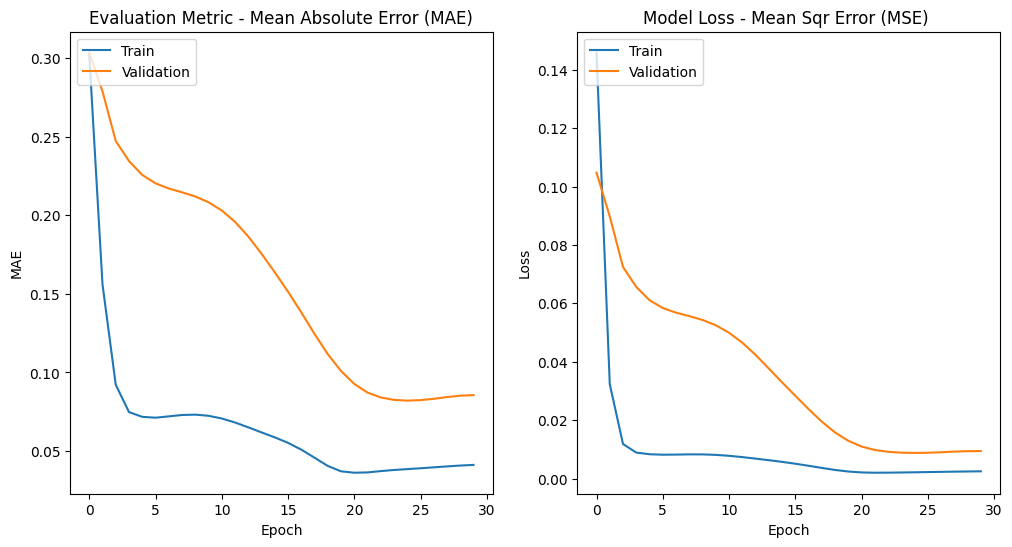

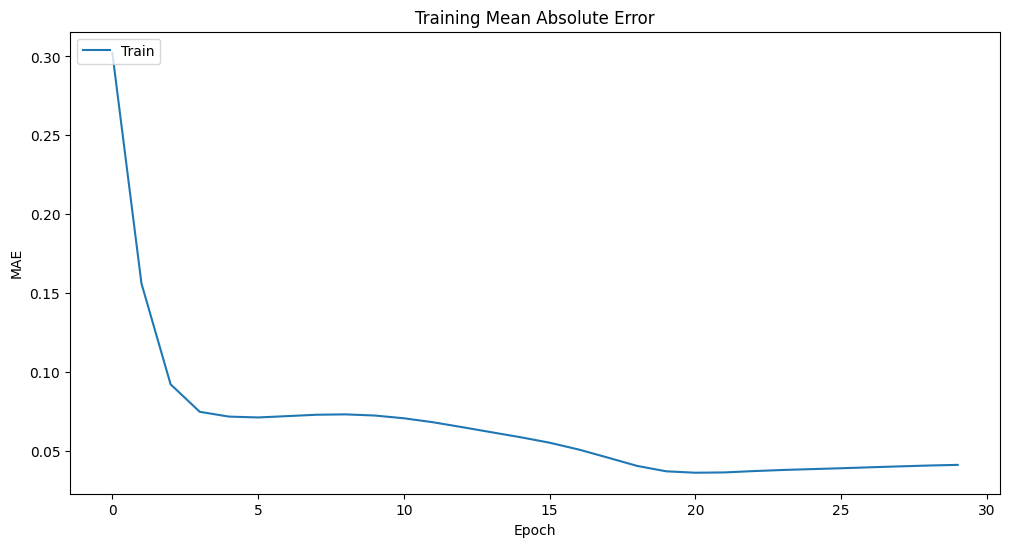

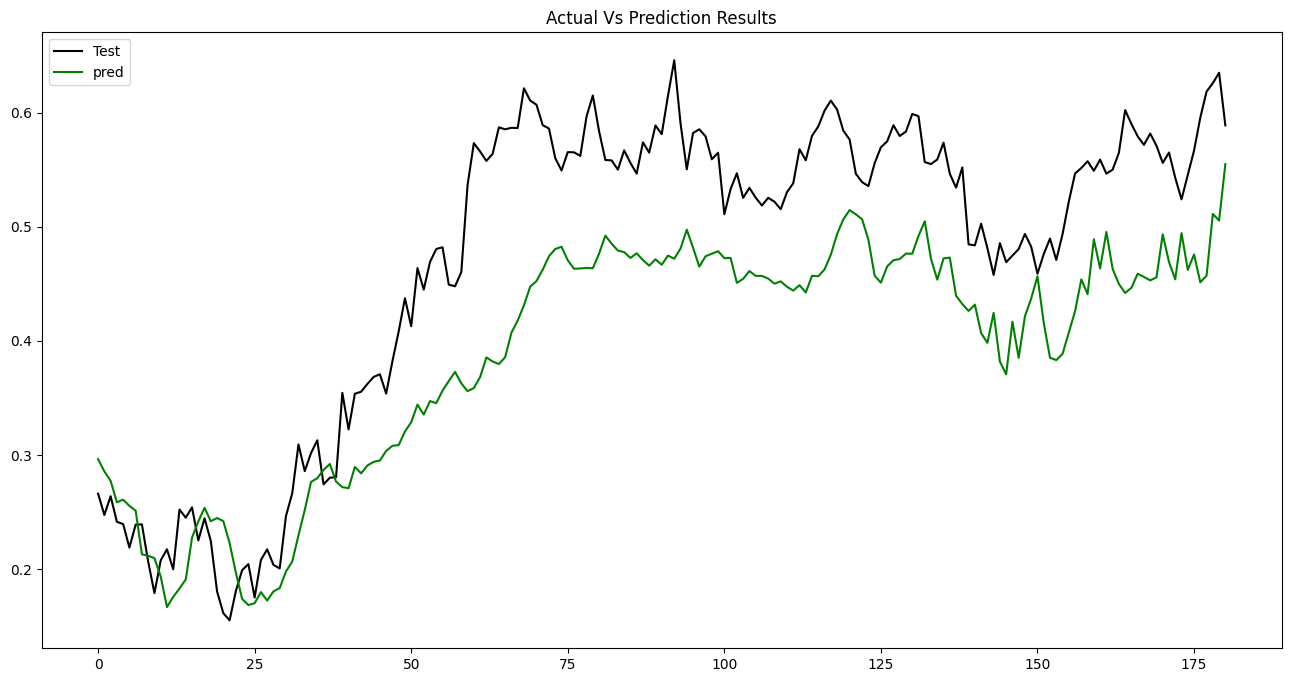

############################################################################
  Model Setup:
                    Name: BTC_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.10192383929900237
             mean_sqr_err =0.012819626683709248
        root_mean_sqr_err =0.11322379027266861
           pred_diff_mean =0.880346974722824
      pred_diff_bias_mean =0.11965302527717593
    pred_correctness_mean =0.994475138121547
                      AIC =-746.5768085425827



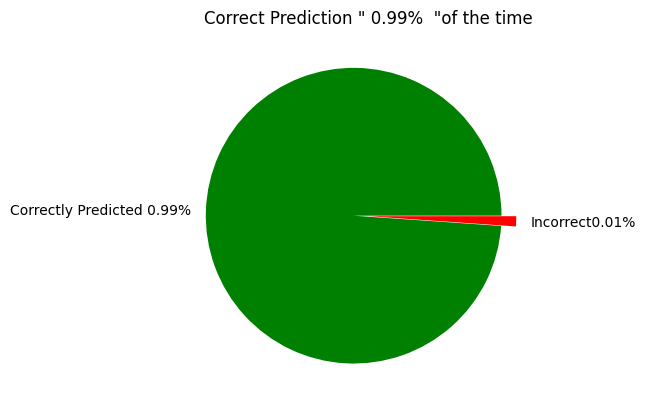

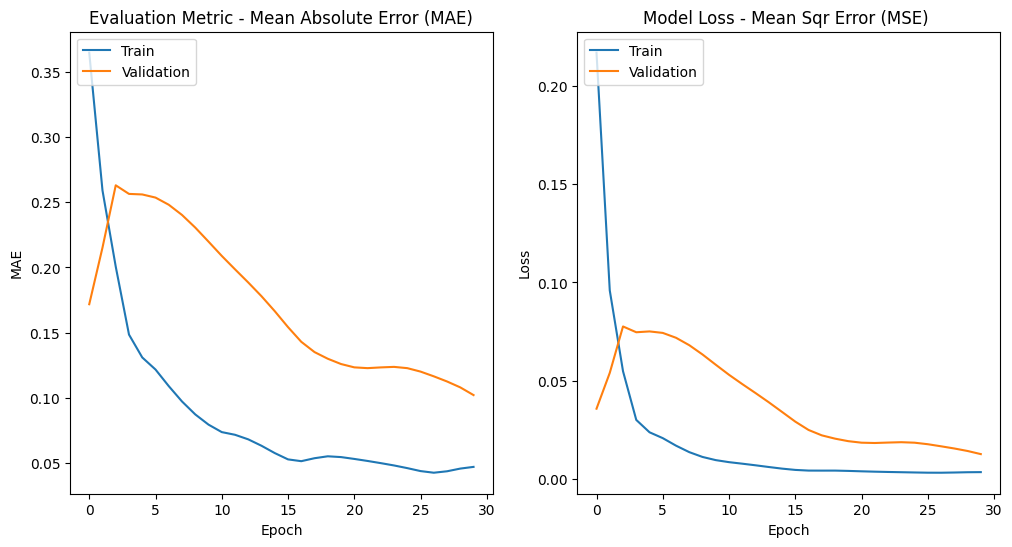

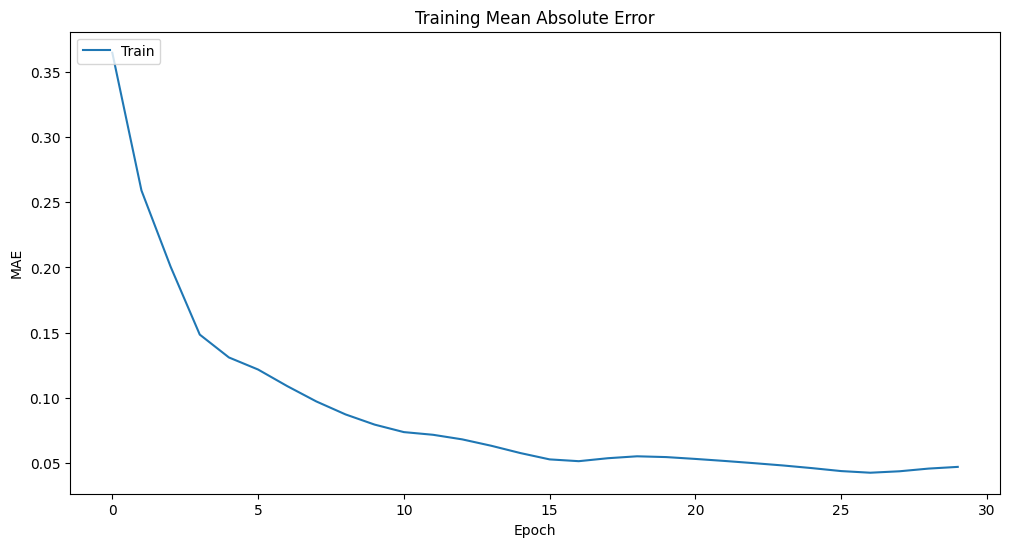

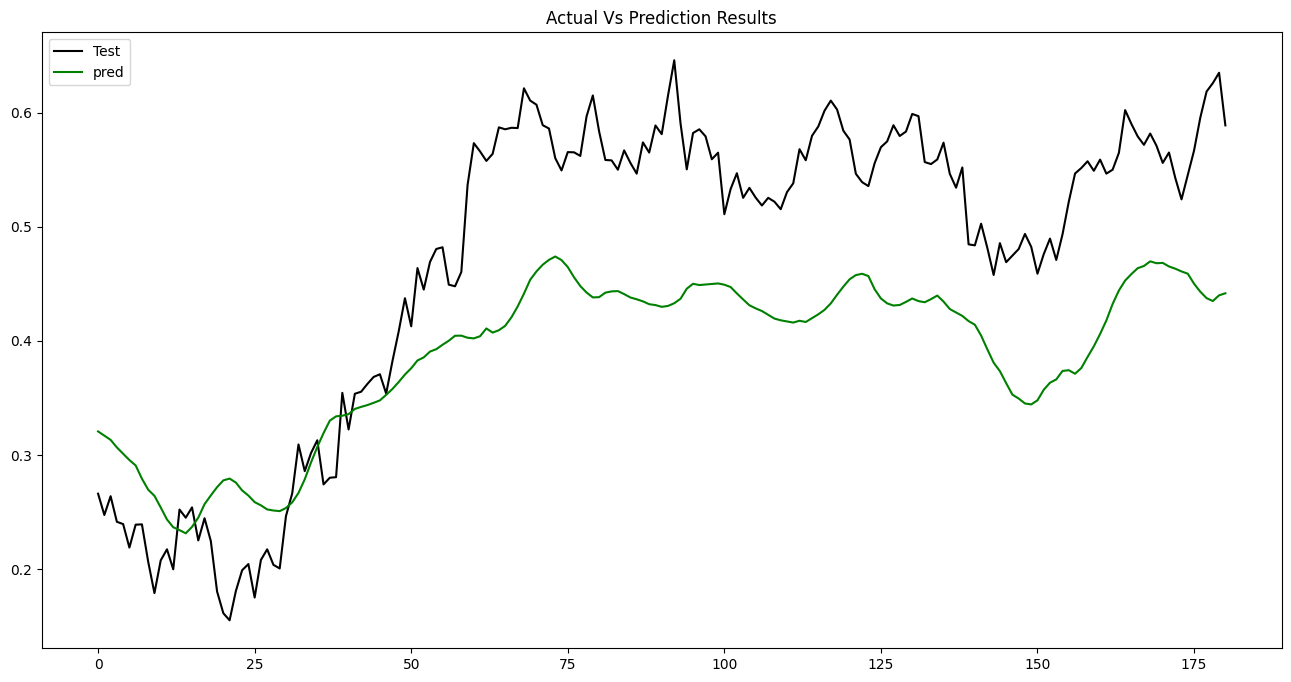

############################################################################
  Model Setup:
                    Name: BTC_F100_L1
             LSTM_Layers: 1
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.08407148565148201
             mean_sqr_err =0.008625182353479142
        root_mean_sqr_err =0.09287185985797389
           pred_diff_mean =0.8680551725610954
      pred_diff_bias_mean =0.13194482743890443
    pred_correctness_mean =0.9938650306748467
                      AIC =-732.7502753385031



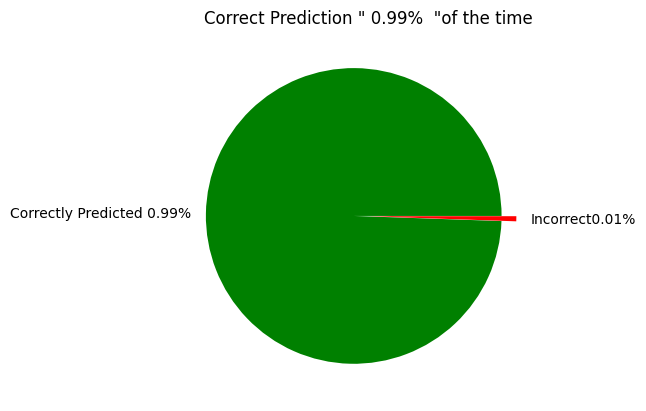

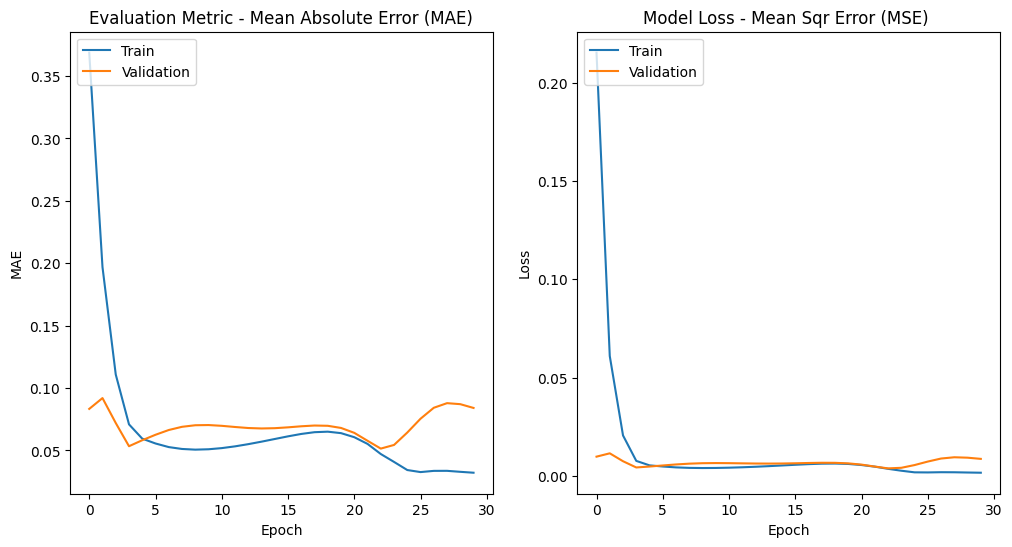

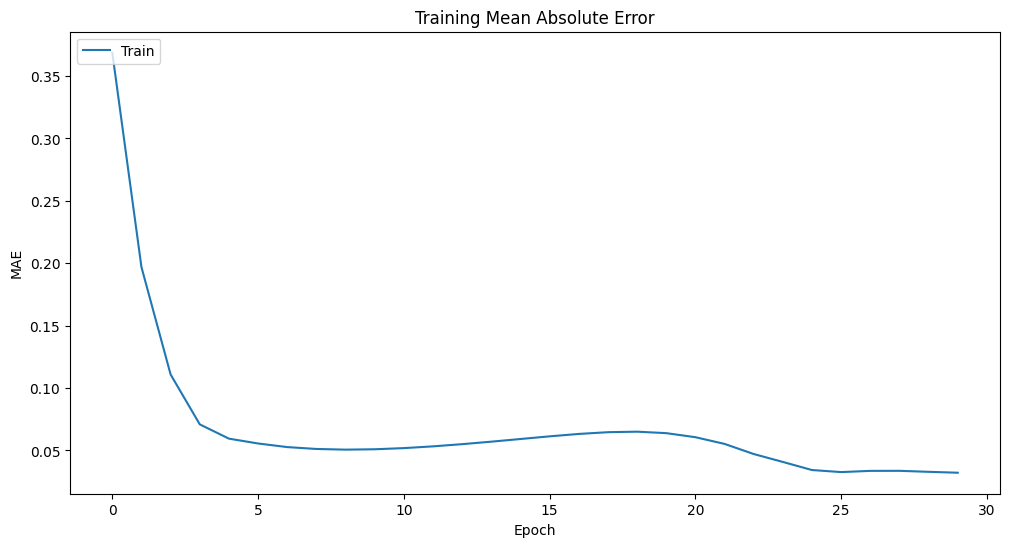

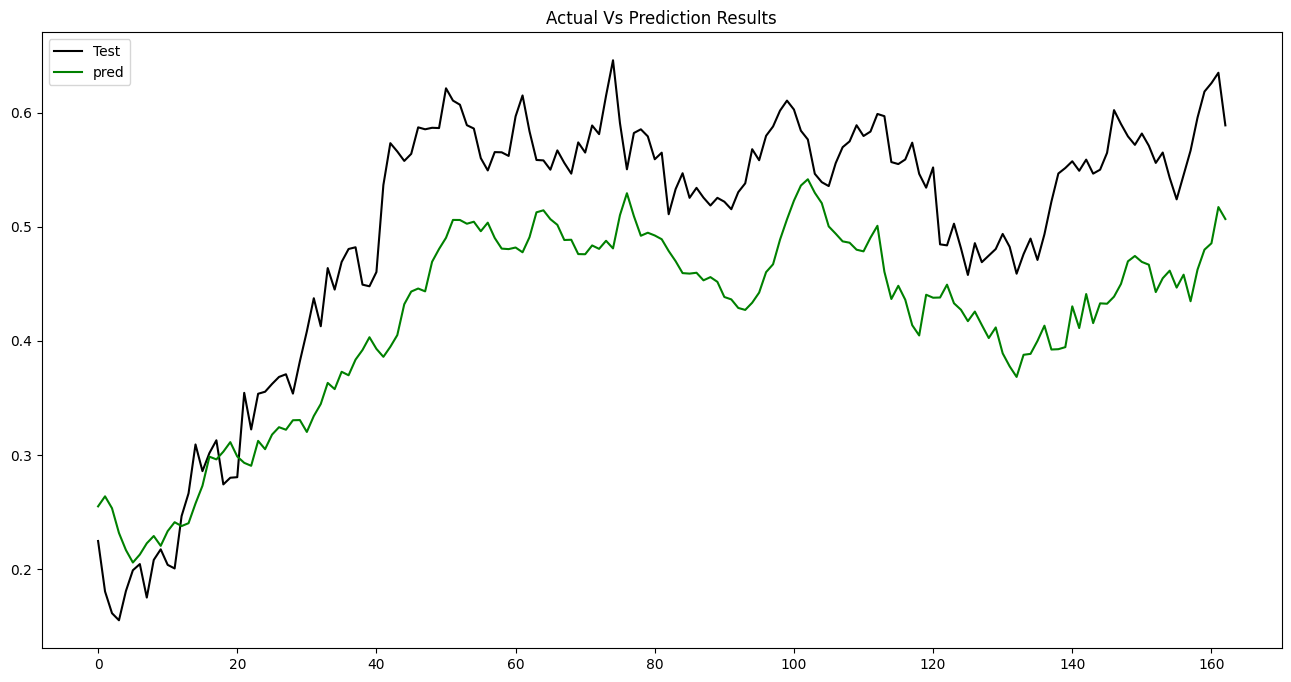

############################################################################
  Model Setup:
                    Name: BTC_F100_L2
             LSTM_Layers: 2
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.1296453205538464
             mean_sqr_err =0.020487035959456175
        root_mean_sqr_err =0.14313293107966515
           pred_diff_mean =0.8021017367076376
      pred_diff_bias_mean =0.19789826329236251
    pred_correctness_mean =0.9754601226993865
                      AIC =-591.7379665719077



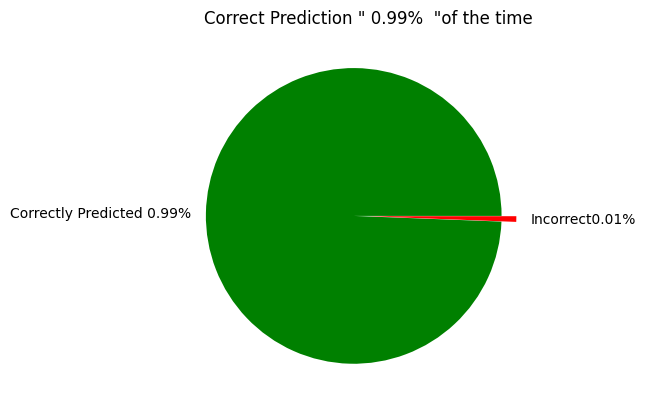

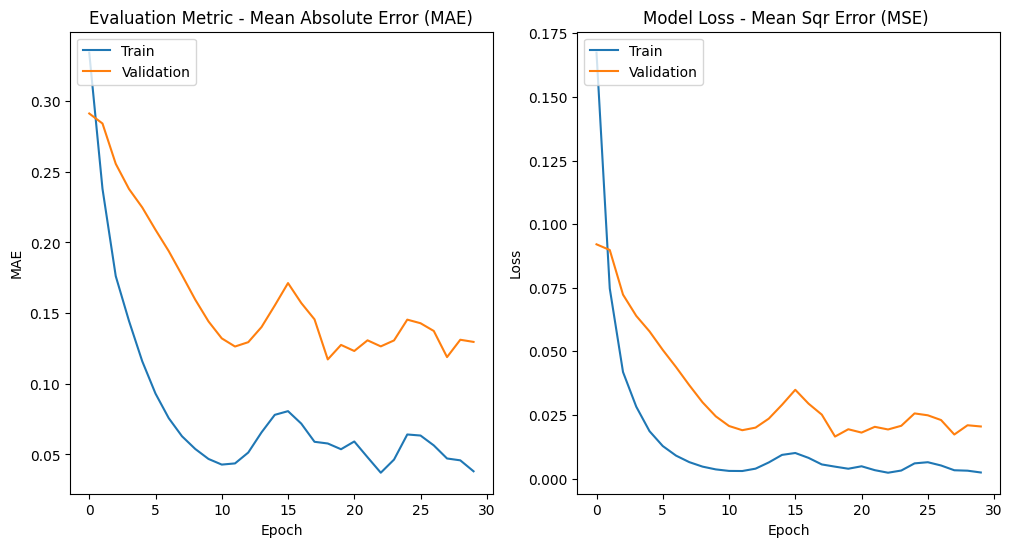

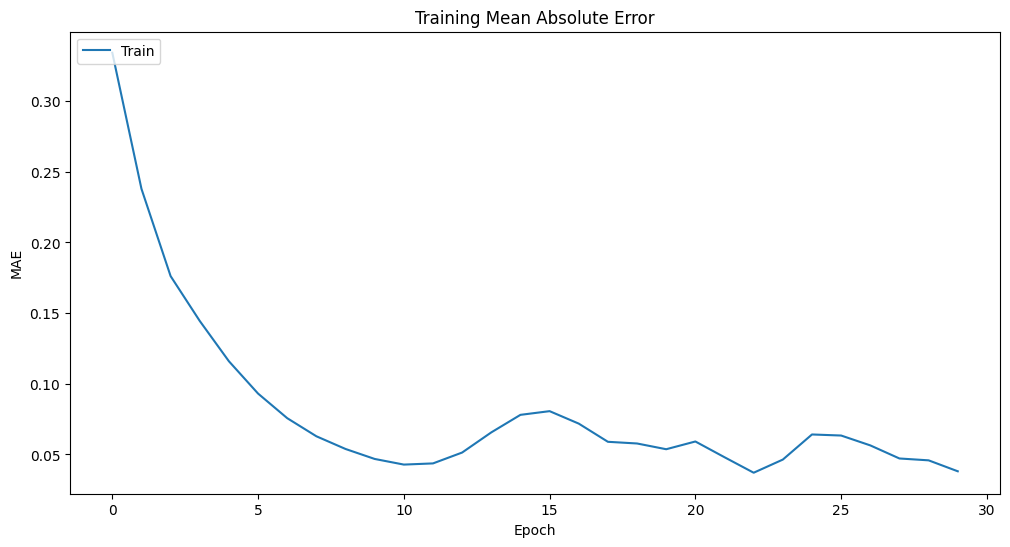

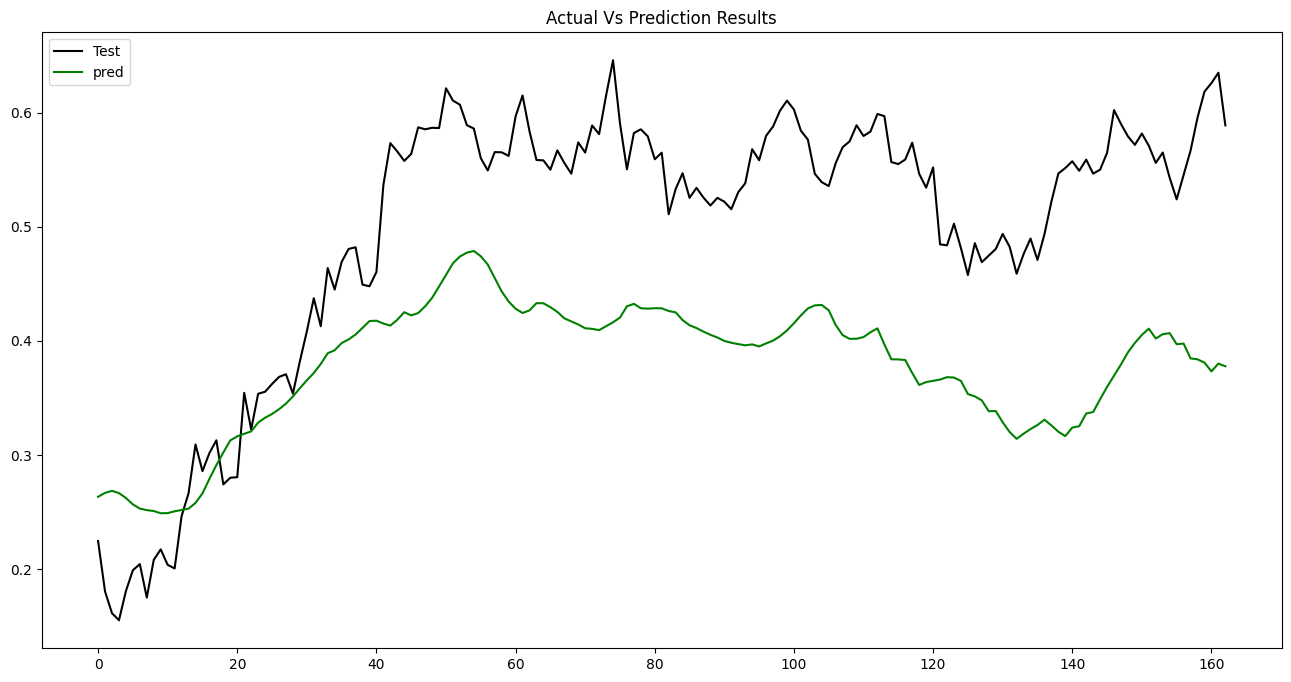

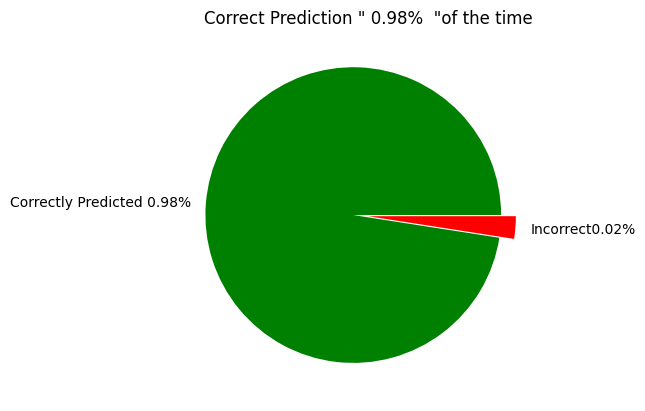

In [102]:
for m in model_list:
  m.View_Performance_Report(show_graphs=True)


In [103]:
from enum import Enum

class CheckDir:
  class Direction(Enum):
    UP = 1
    DOWN = -1
    NONE = 0

  @staticmethod
  def get_direction(last:float,current:float):
    if last < current:
      return CheckDir.Direction.UP
    elif last > current:
      return CheckDir.Direction.DOWN
    else:
      return CheckDir.Direction.NONE



In [104]:
data_length = len(model_list[0].y_test)

In [105]:

# Set Trend
z = model_list[0].y_test
len(z)

model_list[0].y_pred_trend[0] = CheckDir.Direction.NONE
model_list[0].y_test_trend[0] = CheckDir.Direction.NONE

for i in range(len(z)):
  if i > 0: # because we need one to compare against
    model_list[0].y_pred_trend.append(CheckDir.get_direction(model_list[0].y_pred[i-1],model_list[0].y_pred[i]))
    model_list[0].y_test_trend.append(CheckDir.get_direction(model_list[0].y_test[i-1],model_list[0].y_test[i]))








In [106]:
print(f"         Predicted                                        |Key|R|Key|                         Test ")
print(f" Last  |   (trend)         |   Current   |   (trend)      |   | |   |    Last  |   (trend)         |   Current   |   (trend)         ")
for i in range(data_length):
    if i > 0: # because we need one to compare against
      PL = model_list[0].y_pred[i-1]
      PLD = model_list[0].y_pred_trend[i-1]
      PC = model_list[0].y_pred[i]
      PCD = model_list[0].y_pred_trend[i]
      if PLD == PCD:  # If trending the same not a key indicator
         PK = " "
      else:           # trending direction shifted, Key Indicator
         PK = "*"

      TL = model_list[0].y_test[i-1]
      TLD = model_list[0].y_test_trend[i-1]
      TC = model_list[0].y_test[i]
      TCD = model_list[0].y_test_trend[i]
      if TLD == TCD:        # If trending the same not a key indicator
         TK = " "
      else:                 # trending direction shifted, Key Indicator
         TK = "*"

      if PCD == TCD:          # Prediction Results Failed to Trend as Test
        R = " "
      else:
        R = "F"

      # Extract the numerical values, format them, and ensure 5 decimal places
      print(f"{PL[0]:0.5f},   {str(PLD):15s},   {PC[0]:0.5f},   {str(PCD):15s}  | {PK} |{R}| {TK} |    {TL[0]:0.5f},   {str(TLD):15s},   {TC[0]:0.5f},   {str(TCD):15s}")

    #  print(f"{model_list[0].y_pred[i-1]},   {model_list[0].y_pred_trend[i-1]}  ,   {model_list[0].y_pred[i]}")

         Predicted                                        |Key|R|Key|                         Test 
 Last  |   (trend)         |   Current   |   (trend)      |   | |   |    Last  |   (trend)         |   Current   |   (trend)         
0.29642,   Direction.NONE ,   0.28570,   Direction.DOWN   | * | | * |    0.26609,   Direction.NONE ,   0.24746,   Direction.DOWN 
0.28570,   Direction.DOWN ,   0.27734,   Direction.DOWN   |   |F| * |    0.24746,   Direction.DOWN ,   0.26392,   Direction.UP   
0.27734,   Direction.DOWN ,   0.25862,   Direction.DOWN   |   | | * |    0.26392,   Direction.UP   ,   0.24150,   Direction.DOWN 
0.25862,   Direction.DOWN ,   0.26087,   Direction.UP     | * |F|   |    0.24150,   Direction.DOWN ,   0.23948,   Direction.DOWN 
0.26087,   Direction.UP   ,   0.25548,   Direction.DOWN   | * | |   |    0.23948,   Direction.DOWN ,   0.21889,   Direction.DOWN 
0.25548,   Direction.DOWN ,   0.25121,   Direction.DOWN   |   |F| * |    0.21889,   Direction.DOWN ,   0.23898,   Di

In [107]:
#Buy and Sell Results
Shares = 1000
Cash   = 1000
PCD = model_list[0].y_pred[0]
buy_counter = 0
sell_counter = 0
Price = 0

def buy(Shares, Cash, Price, buy_counter):
  cost = 10 * Price
  Cash = Cash - cost
  Shares = Shares + 10
  buy_counter = buy_counter + 1
  return Shares, Cash

def sell(Shares, Cash, Price, sell_counter):
  cost = 10 * Price
  Cash = Cash + cost
  Shares = Shares - 10
  sell_counter = sell_counter + 1
  return Shares, Cash



for i in range(data_length):
    if i > 0: # because we need one to compare against
      PCD = model_list[0].y_pred_trend[i]
      Price = model_list[0].y_test[i]

      if PCD == CheckDir.Direction.UP:  # If trending the same not a key indicator
         Shares, Cash = buy(Shares, Cash, Price, buy_counter)
         print(f"BUY  {model_list[0].y_test[i]}  Cash{Cash}    Shares{Shares}  Value{(Shares * Price) + Cash}   ")
      elif PCD == CheckDir.Direction.DOWN:           # trending direction shifted, Key Indicator
         Shares, Cash = sell(Shares, Cash, Price, sell_counter)
         print(f"SELL {model_list[0].y_test[i]}  Cash{Cash}    Shares{Shares}  Value{(Shares * Price) + Cash}        ")

print(f"Final buy{buy_counter}  sell{sell_counter}  Cash{Cash}  Shares{Shares}  Value{(Shares * Price) + Cash}        ")






SELL [0.24745708]  Cash[1002.47457079]    Shares990  Value[1247.45707917]        
SELL [0.26391718]  Cash[1005.11374256]    Shares980  Value[1263.752576]        
SELL [0.24149948]  Cash[1007.52873732]    Shares970  Value[1241.78322864]        
BUY  [0.23947777]  Cash[1005.13395962]    Shares980  Value[1239.8221741]   
SELL [0.2188893]  Cash[1007.32285264]    Shares970  Value[1219.64547597]        
SELL [0.23898306]  Cash[1009.71268321]    Shares960  Value[1239.13641814]        
SELL [0.23921688]  Cash[1012.10485202]    Shares950  Value[1239.36088838]        
SELL [0.2065275]  Cash[1014.17012702]    Shares940  Value[1208.30597753]        
SELL [0.17895441]  Cash[1015.95967114]    Shares930  Value[1182.38727431]        
SELL [0.20764624]  Cash[1018.03613357]    Shares920  Value[1209.070677]        
SELL [0.21737208]  Cash[1020.20985441]    Shares910  Value[1218.01845023]        
BUY  [0.1998361]  Cash[1018.21149342]    Shares920  Value[1202.0607038]   
BUY  [0.25223053]  Cash[1015.689188

In [127]:
Data_Hold = model_list[0].data_set_scaled

In [134]:
data_length = len(model_list[0].y_test)
for i in range(data_length):
  Data_Hold[i][21] = model_list[0].y_pred[i]
  print(f'Set: {Data_Hold[i][21]}  To:{model_list[0].y_pred[i]}')



Set: 0.2964199483394623  To:[0.29641995]
Set: 0.28569984436035156  To:[0.28569984]
Set: 0.27734267711639404  To:[0.27734268]
Set: 0.25861814618110657  To:[0.25861815]
Set: 0.2608697712421417  To:[0.26086977]
Set: 0.25548413395881653  To:[0.25548413]
Set: 0.25121113657951355  To:[0.25121114]
Set: 0.21295233070850372  To:[0.21295233]
Set: 0.21176786720752716  To:[0.21176787]
Set: 0.20957981050014496  To:[0.20957981]
Set: 0.19359205663204193  To:[0.19359206]
Set: 0.16672618687152863  To:[0.16672619]
Set: 0.17574211955070496  To:[0.17574212]
Set: 0.18302851915359497  To:[0.18302852]
Set: 0.1909339427947998  To:[0.19093394]
Set: 0.22761861979961395  To:[0.22761862]
Set: 0.2417508214712143  To:[0.24175082]
Set: 0.2537183463573456  To:[0.25371835]
Set: 0.24201296269893646  To:[0.24201296]
Set: 0.24481327831745148  To:[0.24481328]
Set: 0.2420440912246704  To:[0.24204409]
Set: 0.22279632091522217  To:[0.22279632]
Set: 0.19693242013454437  To:[0.19693242]
Set: 0.17389002442359924  To:[0.17389002

<ipython-input-134-d6b8723f70b9>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Data_Hold[i][21] = model_list[0].y_pred[i]


In [136]:

rs_data =  model_list[0].reverse_scaling(Data_Hold)



In [147]:
model_list[0].data_set.head()

Price   Adj Close                       Close       High                \
Ticker        BTC          ^DJI          ^DJI        BTC          ^DJI   
0       95.462891  28363.660156  28363.660156  99.779999  28421.310547   
1       95.501175  28335.570312  28335.570312  99.809998  28436.519531   
2       95.568176  27685.380859  27685.380859  99.889999  28185.820312   
3       95.620811  27463.189453  27463.189453  99.930000  27707.689453   
4       95.592102  26519.949219  26519.949219  99.910004  27102.140625   

Price         Low                     Open                Volume             \
Ticker        BTC          ^DJI        BTC          ^DJI     BTC       ^DJI   
0       99.750000  28040.179688  99.779999  28197.419922  5600.0  330320000   
1       99.790001  28149.820312  99.809998  28409.650391  4617.0  347300000   
2       99.860001  27370.160156  99.889999  28185.820312  3900.0  404150000   
3       99.915001  27457.960938  99.930000  27651.179688   710.0  366400000   
4       99.885002  26497.390625  99.910004  27102.140625   704.0  496150000   

Price         RSI       EMAF       EMAM       EMAS        RSI       EMAF  \
Ticker        BTC        BTC        BTC        BTC       ^DJI       ^DJI   
0       21.059995  21.059995  21.059995  21.059995  54.391167  54.391167   
1       29.544946  29.544946  29.544946  29.544946  53.892176  53.892176   
2       41.362262  41.362262  41.362262  41.362262  43.903316  43.903316   
3       48.617536  48.617536  48.617536  48.617536  41.113202  41.113202   
4       45.339209  45.339209  45.339209  45.339209  31.894022  31.894022   

Price        EMAM       EMAS    Target TargetClass TargetNextClose  
Ticker       ^DJI       ^DJI       BTC         BTC             BTC  
0       54.391167  54.391167 -4.308823           0       95.501175  
1       53.892176  53.892176 -4.321823           0       95.568176  
2       43.903316  43.903316 -4.309189           0       95.620811  
3       41.113202  41.113202 -4.317902           0       95.592102  
4       31.894022  31.894022 -4.337967           0       95.482033

In [146]:
rs_data[8][[0,21]]

array([95.38154602, 87.85183737])